In [9]:
# Generate ID3 decision tree
# Don't use scikit
import numpy as np
import pandas as pd
import networkx as nx

In [10]:
## Import data
FILE = 'titanic-homework.csv'
columns_to_omit = [
    'Name']  # Omit name for simplicity, we assume it doesn't affect the chances of survival (it musn't be the case! Our assumption)
df = pd.read_csv(FILE, usecols=lambda column: column not in columns_to_omit)

In [11]:
## PREPROCESS
# Map age to one of 3 categories
# Age[0,20] = young || Age[20,40] = middle || Age[40,99999] = old
df['Age'] = df['Age'].map(lambda x: 'young' if 0 <= x <= 20 else ('middle' if 20 < x <= 40 else 'old'))

In [13]:
## Calculate entropy
def calc_value_entropy(feature, value_key, df):
    survived_sum_by_value = df.loc[df[feature] == value_key, 'Survived'].sum()
    p_survived = survived_sum_by_value / df.shape[0]
    p_no_survived = 1 - p_survived
    entropy = (- p_no_survived * np.log2(p_no_survived, where=(p_no_survived != 0)) -
               p_survived * np.log2(p_survived, where=(p_survived != 0)))
    return entropy


def conditional_entropy(feature, df):
    return (df.loc[df['Feature'] == feature, 'P'] * df.loc[df['Feature'] == feature, 'Entropy']).sum()


# Calculate whole dataset entropy
whole_dataset_entropy = calc_value_entropy('Survived', 1, df)

# Calc features_entropy_df DataFrame, save it to "features_entropy.csv"
#   Feature   Value   P       Cases    Entropy
# 0   Pclass    1     0.21  [2,4...     0.529361  
# 1   Pclass    2     0.19  [10,16...   0.529361
# ...  
# 3   Sex      female 0.40  [2, 3, 4, 9, 10, 11, 12, 15, 16, 19, 20, 23, 2...   
# 4   Sex      male   0.60  [1, 5, 6, 7, 8, 13, 14, 17, 18, 21, 22, 24, 27...   
# ...
features_entropy_list = []
for column in df:

    if column == 'Survived' or column == 'PassengerId':
        continue

    # Get all unique values from column
    values_set = set(df[column].unique())

    # calc P of each decision
    #conditional_entropy = 0
    for value in values_set:
        value_p = df[column].eq(value).sum() / len(df)
        cases = df.loc[df[column] == value, 'PassengerId'].to_list()
        value_entropy = calc_value_entropy(column, value, df)
        features_entropy_list.append([column, value, value_p, cases, value_entropy])

features_entropy_df = pd.DataFrame(features_entropy_list, columns=['Feature', 'Value', 'P', 'Cases', 'Entropy'])
features_entropy_df.to_csv("features_entropy.csv", sep=',', index=False, encoding='utf-8')
print(features_entropy_df)

   Feature   Value     P                                              Cases  \
0   Pclass       1  0.21  [2, 4, 7, 12, 24, 28, 31, 32, 35, 36, 53, 55, ...   
1   Pclass       2  0.19  [10, 16, 18, 21, 22, 34, 42, 44, 54, 57, 59, 6...   
2   Pclass       3  0.60  [1, 3, 5, 6, 8, 9, 11, 13, 14, 15, 17, 19, 20,...   
3      Sex    male  0.60  [1, 5, 6, 7, 8, 13, 14, 17, 18, 21, 22, 24, 27...   
4      Sex  female  0.40  [2, 3, 4, 9, 10, 11, 12, 15, 16, 19, 20, 23, 2...   
5      Age     old  0.21  [7, 12, 16, 20, 27, 30, 32, 33, 34, 36, 47, 49...   
6      Age  middle  0.50  [1, 2, 3, 4, 5, 6, 9, 14, 19, 21, 22, 24, 26, ...   
7      Age   young  0.29  [8, 10, 11, 13, 15, 17, 18, 23, 25, 28, 29, 39...   
8    SibSp       0  0.59  [3, 5, 6, 7, 9, 12, 13, 15, 16, 18, 20, 21, 22...   
9    SibSp       1  0.27  [1, 2, 4, 10, 11, 14, 19, 26, 32, 35, 36, 40, ...   
10   SibSp       2  0.03                                       [39, 49, 70]   
11   SibSp       3  0.06                            

In [ ]:
# Calc gain for each column to draw a decision tree in following block
features_by_gains = []
for df_column in df.columns:

    # Skip 'Survived', already calc in whole_dataset_entropy
    if df_column == 'Survived' or df_column == 'PassengerId':
        continue

    gain = whole_dataset_entropy - conditional_entropy(df_column, features_entropy_df)
    features_by_gains.append((df_column, gain))

features_by_gains.sort(key=lambda x: x[1], reverse=True)
print(features_by_gains)

[]


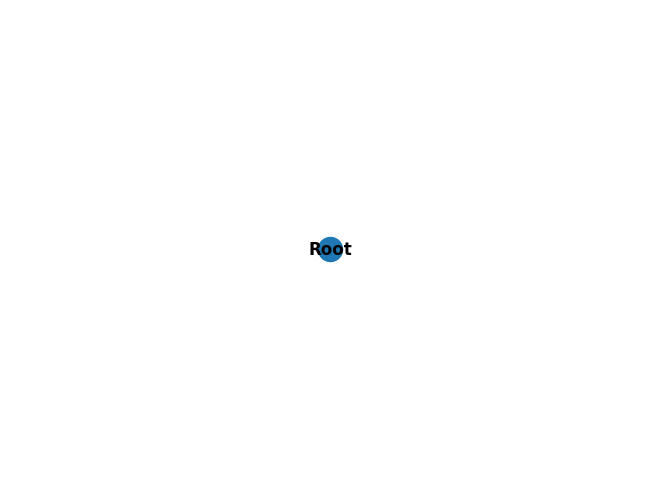

In [109]:
## VISUALIZE
# Print decision tree
# 4) Draw decision tree (use package) with info how many
# how many example in each leaf
features_by_gains.sort(key=lambda x: x[1], reverse=True)
print(features_by_gains)
G = nx.Graph()
G.add_node('Root')
nx.draw(G, with_labels=True, font_weight='bold')